## Import packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from datetime import datetime
import pickle, json, sys, os, glob
import pandas as pd
from scipy.optimize import minimize
from scipy          import optimize

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import utils

from traitlets.config.loader import Config
from astropy.coordinates     import SkyCoord
from lstchain.io.config      import get_standard_config
from lstchain.io.io          import dl1_params_lstcam_key
from ctapipe.io              import read_table

# location of the scripts
sys.path.insert(0, os.path.join("/fefs/aswg/workspace/juan.jimenez/cosmic_ray_data_correction/scripts"))
import auxiliar as aux
import geometry as geom

# latex text
plt.rcParams["mathtext.fontset"] = "stix"
plt.rcParams["font.family"]      = "STIXGeneral"
plt.rcParams["mathtext.rm"]      = "Bitstream Vera Sans"
plt.rcParams["mathtext.it"]      = "Bitstream Vera Sans:italic"
plt.rcParams["mathtext.bf"]      = "Bitstream Vera Sans:bold"
plt.rcParams["font.size"]        = 15

# Some configurations

In [2]:
# Source specifications
source_name = "crab"

# Maybe we add a way to extract the run numbers we are interested in
run_number = 6172 # [6172, 6242, 6194, 6193, 15337, 15272, 15339, 15340] # [15272] # [15337, 15272]
# subrun number
srun = 0

# --- FIT PARAMETERS --- #
total_bins     = np.linspace(4, 6000, 400)   # intensity binning
lims_intensity = [316, 562]                  # limits for the fit
lims_intensity_ext = [60, lims_intensity[1]] # limits for the subsets

# --- INTENSITY BINS --- #
bins_c   = (total_bins[1:] + total_bins[:-1]) / 2
bin_size = np.diff(total_bins)
# mask for the fits
mask_bins = []
for b in bins_c:
    if b >= lims_intensity[0] and b <= lims_intensity[1]:
        mask_bins.append(True)
    else:
        mask_bins.append(False)
# limits for plotting the power law
bins_space = np.linspace(lims_intensity[0] - 100, lims_intensity[1] + 200, 100)


### Taking the reference power law and parameter fits

In [3]:
####################################
# --- POWER LAW PARAMETERS REF --- #
reference_rates       = 1.74 
reference_intensity   = 422
reference_power_index = -2.23
####################################
    
###############################
# --- PARAMETERS RELATION --- #
p0a, p0b, p0c = -0.44751321, 3.62502037, -1.43611437
p1a, p1b, p1c = -2.89253919, 0.99443581, -0.34013068
###############################

# some functions needed 
def plaw(I, A, alpha):
    return  A * (I / reference_intensity) ** alpha

def likelihood_plaw(params, x, y):
    A, k = params[0], params[1]
    y_pred = plaw(x, A, k)
    return np.sum((y - y_pred)**2)

def calc_light_yield(refpoint, AR, alphaR, A2, alpha2):
    return (A2 / AR) ** (-1 / ( 1+ alpha2))

def pol2(x, a, b, c):
    return a + b * x + c * x * x

# Paths to data and results

In [9]:
# Root path of this script
root = "/fefs/aswg/workspace/juan.jimenez/lst_pipeline/"
# Path to store the configuration file we are going to use
config_file = root + "objects/standard_config.json"
# Data main directory
root_data = root + f"../data/cosmic_ray_data_correction/{source_name}/"

# STANDARD paths ---------
# DL1 data root
dl1_root = "/fefs/aswg/data/real/DL1/*/v0.*/tailcut84/"
rfs_root = "/fefs/aswg/data/models/AllSky/20230901_v0.10.4_allsky_base_prod/"
mcs_root = "/fefs/aswg/data/mc/DL2/AllSky/20230901_v0.10.4_allsky_base_prod/TestingDataset/"

# Opening and storing configuration file

In [5]:
config_dict = get_standard_config()

# We select the heuristic flatfield option in the standard configuration
config_dict["source_config"]["LSTEventSource"]["use_flatfield_heuristic"] = True

with open(config_file, "w") as json_file:
    json.dump(config_dict, json_file)

# Finding the files that interest us
#### Extracting dl1 files and dl1 datachecks

In [6]:
# Getting coordinates of source
source_coords = SkyCoord.from_name(source_name)

dict_source = {
    "name"   : source_name,
    "coords" : source_coords,
    "ra"     : source_coords.ra.deg  * u.deg, # ra in degrees
    "dec"    : source_coords.dec.deg * u.deg, # dec in degrees
}

# We create a empty dictionary to store all the information needed inside
DICT = {}
for run in [run_number]:
    DICT[run] = {
        "run_num" : run,
        "errors"  : "", # log of errors trough the analysis
    }

DICT = utils.add_dl1_paths_to_dict(DICT, dl1_root)
DICT = utils.add_dl1_paths_to_dict(DICT, dl1_root, dchecking=True)


Adding dl1  data to dictionary...
...Finished adding dl1 data to dictionary

Adding dl1 datacheck data to dictionary...
...Finished adding dl1 data to dictionary


#### Then we read the observations information and also the selected nodes for MC and RFs and we add it to the DICT

In [10]:
for run in [run_number]:

    tab = read_table(DICT[run]["dchecks"]["runwise"], "/dl1datacheck/cosmics")
    
    # reading the variables
    _zd,     _az       = 90 - np.rad2deg(np.array(tab["mean_alt_tel"])), np.rad2deg(np.array(tab["mean_az_tel"]))
    _t_start, _t_elapsed = tab["dragon_time"][0][0],                       np.array(tab["elapsed_time"])
    
    DICT[run]["time"] = {
        "tstart"   : _t_start,            # datetime object
        "telapsed" : np.sum(_t_elapsed),  # s
        "srunwise" : {
            "telapsed" : _t_elapsed,      # s      
        },
    }
    DICT[run]["pointing"] = {
        "zd" : np.mean(_zd),  # deg
        "az" : np.mean(_az),  # deg
        "srunwise" : {
            "zd" : _zd,       # deg
            "az" : _az,       # deg
        },
    }
    
# then we also select the RFs and MC files looking at the nodes available
DICT, dict_nodes = utils.add_mc_and_rfs_nodes(DICT, rfs_root, mcs_root, dict_source)

## Read datacheck

In [11]:
# input fname of the dl1a
input_fname  = DICT[run_number]["dl1a"]["srunwise"][srun]

dir_objects = "/fefs/aswg/workspace/juan.jimenez/cosmic_ray_data_correction/analysis_weather/objects"
with open(dir_objects + "/data_dict.pkl", "rb") as f:
    dict_dcheck = pickle.load(f)  

_index_run  = list(dict_dcheck["run"]).index(run_number)
lightyield  = dict_dcheck["light_yield"][_index_run]
telapsed    = dict_dcheck["telapsed"][_index_run]
zd_run      = dict_dcheck["zd"][_index_run]

print(f"Analysing Run {run_number} Subrun {srun}:\n")
print(f"Zenith Distance = {zd_run:.2f} deg\nTime elapsed    = {telapsed:.2f} s\nDatacheck L.Y.  = {1/lightyield:.2f}")

Analysing Run 6172 Subrun 0:

Zenith Distance = 26.66 deg
Time elapsed    = 10.70 s
Datacheck L.Y.  = 1.65


## Generate DL1 non-scaled files

In [12]:
"""
%%time
output_fname = f"dl1_LST-1.Run{run_number:05}.{srun:04}_onlyrange_1.h5"

!lstchain_dl1ab \
  -f $input_fname \
  -o $output_fname \
  -c $config_file \
  --no-image \
  --light-scaling $1

"""

'\n%%time\noutput_fname = f"dl1_LST-1.Run{run_number:05}.{srun:04}_onlyrange_1.h5"\n\n!lstchain_dl1ab   -f $input_fname   -o $output_fname   -c $config_file   --no-image   --light-scaling $1\n\n'

## Reading the total and reduced subset

In [13]:
# reading the files
dl1b_df_total1 = read_table(f"dl1_LST-1.Run{run_number:05}.{srun:04}_test_1.h5",      dl1_params_lstcam_key)
dl1b_df_sub1   = read_table(f"dl1_LST-1.Run{run_number:05}.{srun:04}_onlyrange_1.h5", dl1_params_lstcam_key)

# histograms
hist_tot_1, _ = np.histogram(dl1b_df_total1["intensity"], total_bins)
hist_lim_1, _ = np.histogram(dl1b_df_sub1["intensity"],   total_bins)
# calculating rates
rate_tot_1 = hist_tot_1 / telapsed / bin_size
rate_lim_1 = hist_lim_1 / telapsed / bin_size
# parameters of the plaw
a_1, p_index_1 = minimize(likelihood_plaw, x0=[reference_rates, reference_power_index], args=(bins_c[mask_bins], rate_lim_1[mask_bins])).x
# zd corrections
zd_corr_a_1       = a_1       * pol2(1, p0a, p0b, p0c) / pol2(np.cos(np.rad2deg(zd_run)), p0a, p0b, p0c)
zd_corr_p_index_1 = p_index_1 + pol2(1, p1a, p1b, p1c) - pol2(np.cos(np.rad2deg(zd_run)), p1a, p1b, p1c)

# calculating light yield
ly1 = calc_light_yield(reference_intensity, reference_rates, reference_power_index, zd_corr_a_1, zd_corr_p_index_1)

print(f"Computed the rates of original data:\n\nLight Yield = {ly1:.2f}\n1/LY        = {1/ly1:.2f}\n(1+1/LY)/2  = {(1+1/ly1)/2:.2f}")

Computed the rates of original data:

Light Yield = 0.70
1/LY        = 1.43
(1+1/LY)/2  = 1.22


## Generating scaled by 1/LY and (1+1/LY)/2

In [15]:
"""
%%time
print(ly1, 1/ly1, (1+1/ly1)/2)
output_fname = f"dl1_LST-1.Run{run_number:05}.{srun:04}_test_2.h5"

scale = 1/ly1

!lstchain_dl1ab \
  -f $input_fname \
  -o $output_fname \
  -c $config_file \
  --no-image \
  --light-scaling $scale

output_fname = f"dl1_LST-1.Run{run_number:05}.{srun:04}_test_3.h5"

scale = (1+1/ly1)/2

!lstchain_dl1ab \
  -f $input_fname \
  -o $output_fname \
  -c $config_file \
  --no-image \
  --light-scaling $scale
"""

'\n%%time\nprint(ly1, 1/ly1, (1+1/ly1)/2)\noutput_fname = f"dl1_LST-1.Run{run_number:05}.{srun:04}_test_2.h5"\n\nscale = 1/ly1\n\n!lstchain_dl1ab   -f $input_fname   -o $output_fname   -c $config_file   --no-image   --light-scaling $scale\n\noutput_fname = f"dl1_LST-1.Run{run_number:05}.{srun:04}_test_3.h5"\n\nscale = (1+1/ly1)/2\n\n!lstchain_dl1ab   -f $input_fname   -o $output_fname   -c $config_file   --no-image   --light-scaling $scale\n'

In [16]:
# reading the files
dl1b_df_sub2   = read_table(f"dl1_LST-1.Run{run_number:05}.{srun:04}_onlyrange_2.h5", dl1_params_lstcam_key)
dl1b_df_sub3   = read_table(f"dl1_LST-1.Run{run_number:05}.{srun:04}_onlyrange_3.h5", dl1_params_lstcam_key)
dl1b_df_total2 = read_table(f"dl1_LST-1.Run{run_number:05}.{srun:04}_test_2.h5",      dl1_params_lstcam_key)
dl1b_df_total3 = read_table(f"dl1_LST-1.Run{run_number:05}.{srun:04}_test_3.h5",      dl1_params_lstcam_key)

# histograms
hist_tot_2, _ = np.histogram(dl1b_df_total2["intensity"], total_bins)
hist_tot_3, _ = np.histogram(dl1b_df_total3["intensity"], total_bins)
hist_lim_2, _ = np.histogram(dl1b_df_sub2["intensity"], total_bins)
hist_lim_3, _ = np.histogram(dl1b_df_sub3["intensity"], total_bins)
# rates
rate_tot_2 = hist_tot_2 / telapsed / bin_size
rate_tot_3 = hist_tot_3 / telapsed / bin_size
rate_lim_2 = hist_lim_2 / telapsed / bin_size
rate_lim_3 = hist_lim_3 / telapsed / bin_size
# fitting the power laws
a_2, p_index_2 = minimize(likelihood_plaw, x0=[reference_rates, reference_power_index], args=(bins_c[mask_bins], rate_lim_2[mask_bins])).x
a_3, p_index_3 = minimize(likelihood_plaw, x0=[reference_rates, reference_power_index], args=(bins_c[mask_bins], rate_lim_3[mask_bins])).x
# correcting by ZD
zd_corr_a_2       = a_2       * pol2(1, p0a, p0b, p0c) / pol2(np.cos(np.rad2deg(zd_run)), p0a, p0b, p0c)
zd_corr_p_index_2 = p_index_2 + pol2(1, p1a, p1b, p1c) - pol2(np.cos(np.rad2deg(zd_run)), p1a, p1b, p1c)
zd_corr_a_3       = a_3       * pol2(1, p0a, p0b, p0c) / pol2(np.cos(np.rad2deg(zd_run)), p0a, p0b, p0c)
zd_corr_p_index_3 = p_index_3 + pol2(1, p1a, p1b, p1c) - pol2(np.cos(np.rad2deg(zd_run)), p1a, p1b, p1c)

# calculating light yields
ly2 = calc_light_yield(reference_intensity, reference_rates, reference_power_index, zd_corr_a_2, zd_corr_p_index_2)
ly3 = calc_light_yield(reference_intensity, reference_rates, reference_power_index, zd_corr_a_3, zd_corr_p_index_3)

print(f"Computed the rates of data scaled by 1/LY ({1/ly1:.2f}):\n\nLight Yield = {ly2:.2f}\n1/LY        = {1/ly2:.2f}\n")
print(f"Computed the rates of data scaled by (1+1/LY)/2 ({(1+1/ly1)/2:.2f}):\n\nLight Yield = {ly3:.2f}\n1/LY        = {1/ly3:.2f}")

Computed the rates of data scaled by 1/LY (1.43):

Light Yield = 1.37
1/LY        = 0.73

Computed the rates of data scaled by (1+1/LY)/2 (1.22):

Light Yield = 0.97
1/LY        = 1.03


### Fitting the 3 points to a polynomial of deg 2

In [17]:
poly_fit      = np.poly1d(np.polyfit([1, (1 + 1/ly1)/2, 1/ly1], [ly1, ly3, ly2], 2))
final_scaling = optimize.root(poly_fit - 1, x0=(1 + 1/ly1)/2, method="hybr").x[0]

print(f"The optimal scaling factor so the (LY = 1) will be the following: {final_scaling:.2f}")

The optimal scaling factor so the (LY = 1) will be the following: 1.24


# Generating the final scale dataset

In [18]:
"""
%%time
output_fname = f"dl1_LST-1.Run{run_number:05}.{srun:04}_onlyrange_f.h5"

!lstchain_dl1ab \
  -f $input_fname \
  -o $output_fname \
  -c $config_file \
  --no-image \
  --light-scaling $final_scaling
"""

'\n%%time\noutput_fname = f"dl1_LST-1.Run{run_number:05}.{srun:04}_onlyrange_f.h5"\n\n!lstchain_dl1ab   -f $input_fname   -o $output_fname   -c $config_file   --no-image   --light-scaling $final_scaling\n'

In [19]:
# reading the file
dl1b_df_totalf = read_table(f"dl1_LST-1.Run{run_number:05}.{srun:04}_test_f.h5", dl1_params_lstcam_key)

# histograms
hist_tot_f, _ = np.histogram(dl1b_df_totalf["intensity"], total_bins)
rate_tot_f = hist_tot_f / telapsed / bin_size

result_f = minimize(likelihood_plaw, x0=[reference_rates, reference_power_index], args=(bins_c[mask_bins], rate_tot_f[mask_bins]))
a_f, p_index_f = result_f.x

correction_a = pol2(1, p0a, p0b, p0c) / pol2(np.cos(np.rad2deg(zd_run)), p0a, p0b, p0c)
correction_index = pol2(1, p1a, p1b, p1c) - pol2(np.cos(np.rad2deg(zd_run)), p1a, p1b, p1c)
zd_corr_a_f       = a_f       * correction_a
zd_corr_p_index_f = p_index_f + correction_index

# calculating light yield
lyf = calc_light_yield(reference_intensity, reference_rates, reference_power_index, zd_corr_a_f, zd_corr_p_index_f)

print(f"Computed the rates of data scaled by optimal scaling ({final_scaling:.3f}):\n\nLight Yield = {lyf:.3f}\n1/LY        = {1/lyf:.3f}\n")

Computed the rates of data scaled by optimal scaling (1.236):

Light Yield = 0.992
1/LY        = 1.008



## Scheme plots
* **Intensity changes with changes in the scale applied**

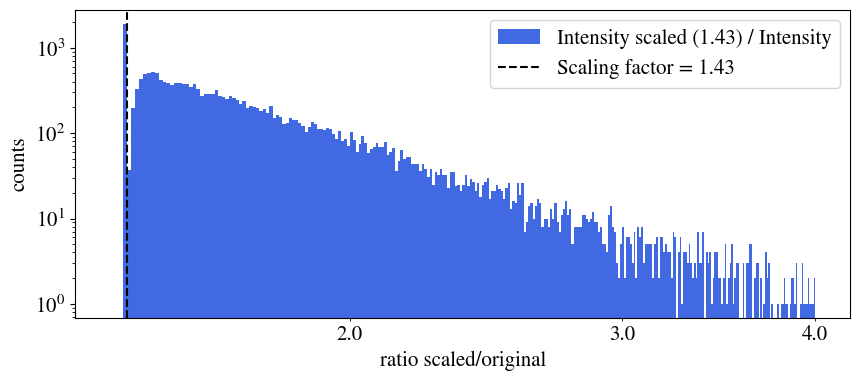

In [20]:
fig, ax = plt.subplots(figsize=(10,4))

ax.hist(dl1b_df_sub2["intensity"] / dl1b_df_sub1["intensity"], bins=np.linspace(1.4, 4, 300), color="royalblue",
        label="Intensity scaled (1.43) / Intensity")
ax.axvline(1/ly1, color="k", ls="--", label=f"Scaling factor = {1/ly1:.2f}")
ax.set_yscale("log")
ax.set_xscale("log")
ax.legend()
ax.set_xlabel("ratio scaled/original")
ax.set_ylabel("counts")
import matplotlib.ticker as mticker
ax.xaxis.set_minor_formatter(mticker.ScalarFormatter())

# plt.savefig(f"plots/total.png", dpi=300, bbox_inches="tight")
plt.show()

* **General algorithm plots**

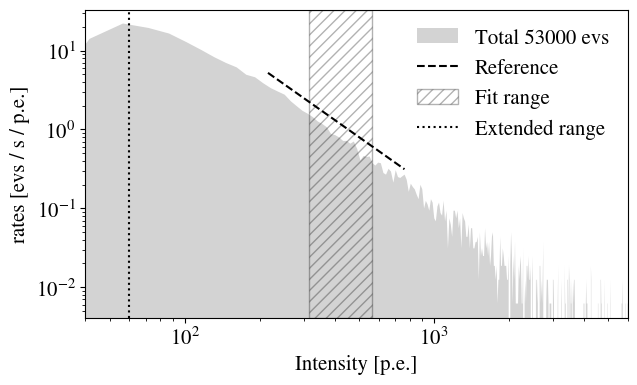

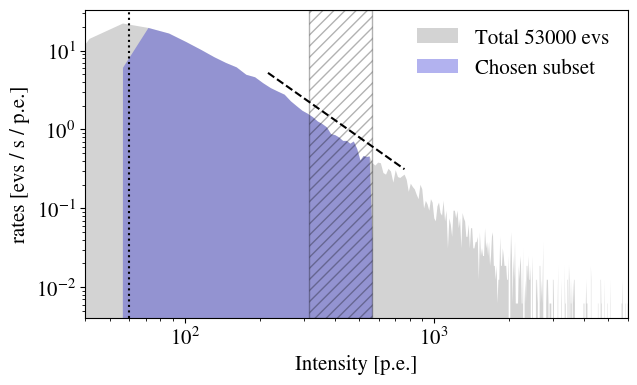

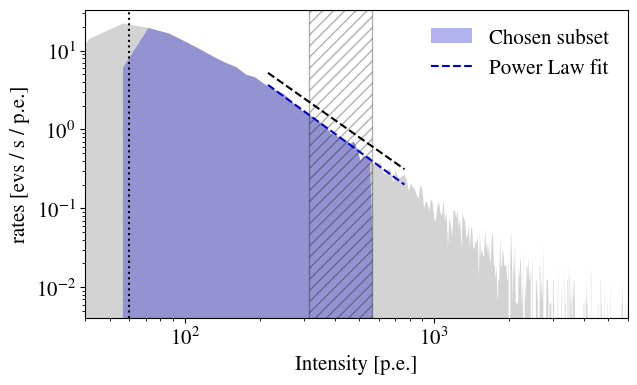

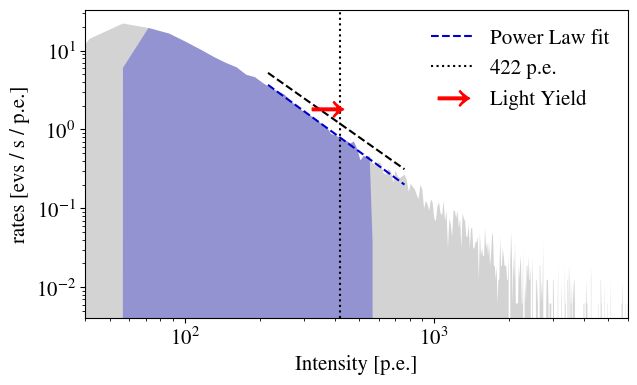

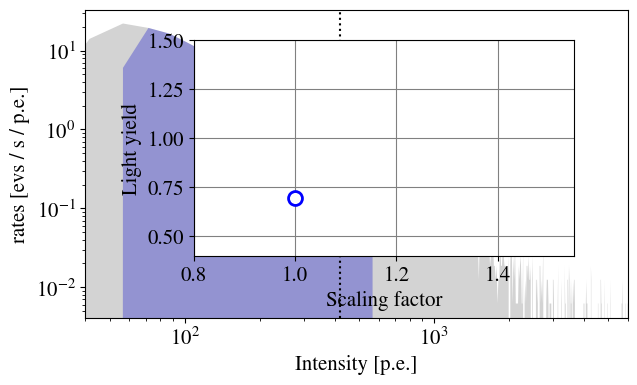

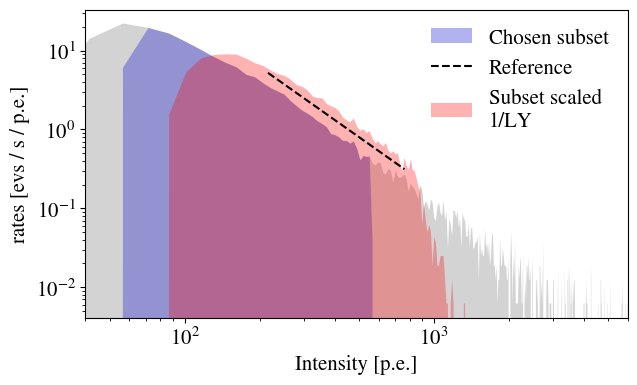

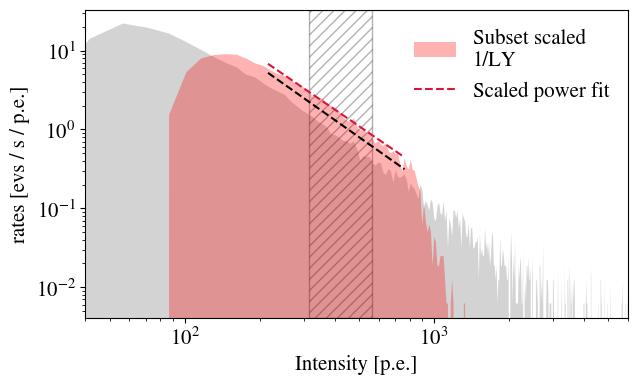

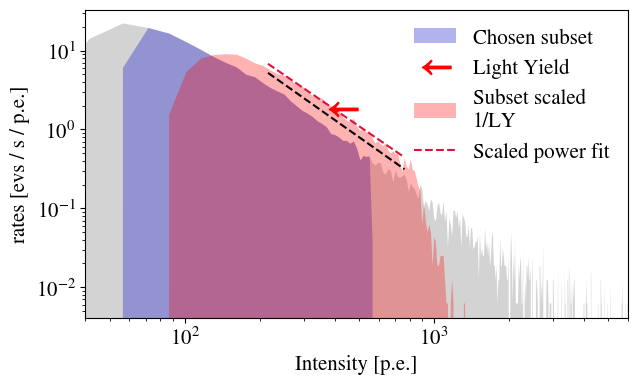

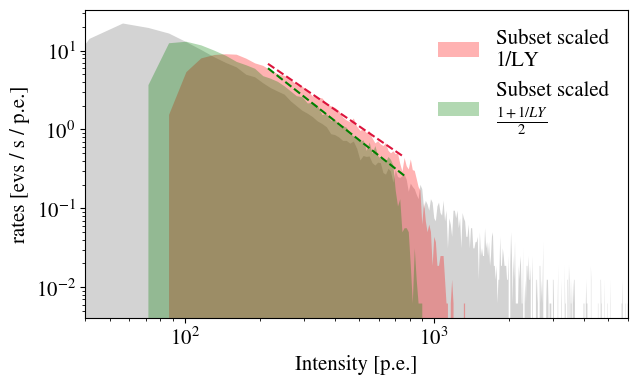

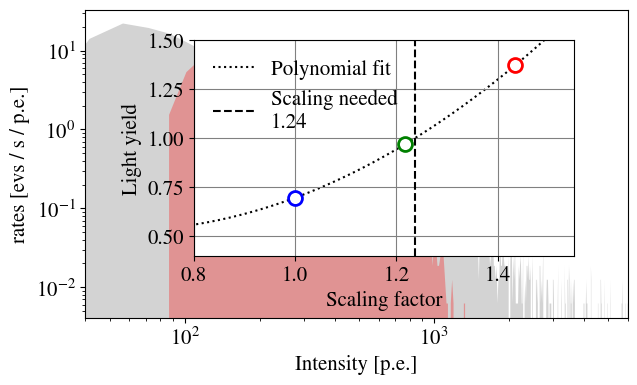

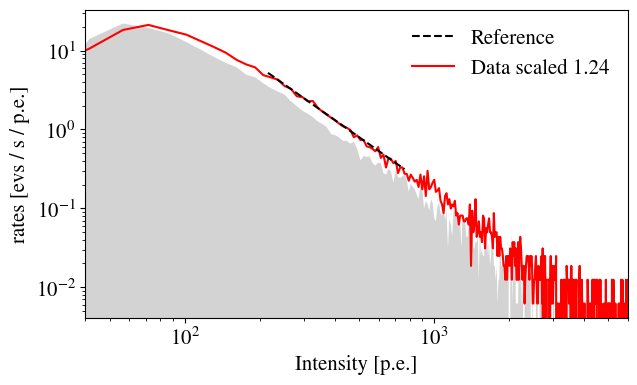

In [25]:
for i in range(11):
    fig, ax = plt.subplots(figsize=(7,4))
    
    # plot total distribution
    ax.fill_between(bins_c, rate_tot_1, color="lightgray", lw=0, label=f"Total {len(dl1b_df_totalf)} evs" if i in [0, 1] else "")
    # plot blue distribution
    if i in [1, 2, 3, 4, 5, 7]:
        ax.fill_between(bins_c, rate_lim_1, color="mediumblue", alpha=0.3, lw=0, label=f"Chosen subset" if i in [1, 2, 5, 7, 8] else "")
    # plot reference power law
    if i in [0, 1, 2, 3, 5, 6, 7, 10]:
        ax.plot(bins_space, plaw(bins_space, reference_rates/correction_a, reference_power_index), 
                color="k", ls="--", zorder=10, label="Reference" if i in [0, 5, 10] else "")
    # inset defnition
    if i in [4, 9]:
        ins = ax.inset_axes([0.2,0.2,0.7,0.7])
        ins.set_ylim(0.4, 1.5)
        ins.set_xlim(0.8, 1.55)
        ins.set_xlabel("Scaling factor")
        ins.set_ylabel("Light yield")
        ins.grid(color="gray")
    # integration range
    if i in [0, 1, 2, 6]:
        ax.axvspan(lims_intensity[0], lims_intensity[1], alpha=0.3, ls="-", facecolor="none", hatch="///", edgecolor="k", 
                   label="Fit range" if i in [0] else "")
    # axvline extended range
    if i in [0, 1, 2]:
        ax.axvline((lims_intensity_ext[0]), color="k", ls=":", label="Extended range" if i == 0 else "")
    # blue fit
    if i in [2, 3, 4]:
        ax.plot(bins_space, plaw(bins_space, a_1, p_index_1), color="mediumblue", ls="--", label="Power Law fit" if i in [2, 3, 4] else "")
    # 422 p.e.
    if i in [3, 4]:
        ax.axvline(reference_intensity, color="k", ls=":", label="422 p.e.")
    # arrows
    if i == 3:
        ax.scatter([reference_intensity/2 + (reference_intensity-70)/2 - 18], [reference_rates], 
                   c="r", marker=r"$\rightarrow$", s=600, label="Light Yield", zorder=10)
    if i == 7:
        ax.scatter([reference_intensity/2 + (reference_intensity-30)/2+20], [reference_rates], 
                   c="r", marker=r"$\leftarrow$", s=500, label="Light Yield", zorder=10)
    # blue dot
    if i in [4, 9]:
        ins.plot([1], [ly1], color="b", marker="o", ms=10, mfc="w", markeredgewidth=2)
    # scaled red
    if i in [5, 6, 7, 8, 9]:
        ax.fill_between(bins_c, rate_lim_2, color="r", alpha=0.3, lw=0, label=f"Subset scaled\n1/LY")
    # red plaw
    if i in [6, 7, 8, 9]:
        ax.plot(bins_space, plaw(bins_space, a_2, p_index_2), color="crimson", ls="--", label="Scaled power fit" if i in [6, 7] else "")
    # green scaled
    if i in [8]:
        ax.fill_between(bins_c, rate_lim_3, label="Subset scaled\n$\\frac{1+1/LY}{2}$", color="g", alpha=0.3, lw=0)
    # gren plaw
    if i in [8]:
        ax.plot(bins_space, plaw(bins_space, a_3, p_index_3), color="g", ls="--", label="")
    # other dots
    if i == 9:
        ins.plot([(1 + 1/ly1)/2], [ly3], color="g", marker="o", ms=10, mfc="w", markeredgewidth=2, ls="")
        ins.plot([1/ly1], [ly2], color="r", marker="o", ms=10, mfc="w", markeredgewidth=2, ls="")
    
        xp = np.linspace(-1, 3, 200)
        ins.plot(xp, poly_fit(xp), ":", color="k", label="Polynomial fit", zorder=-10)
        ins.axvline(final_scaling, color="k", ls="--", label=f"Scaling needed\n{final_scaling:.2f}")
    # result
    if i == 10:
        ax.plot(bins_c, rate_tot_f, label=f"Data scaled {final_scaling:.2f}", color="r",)
    
    # plot legends
    if i in [0, 1, 2, 3, 5, 6, 7, 8, 10]:
        ax.legend(loc=1, frameon=False)
    if i in [9]:
        ins.legend(frameon=False)
    
    
    ax.loglog()
    ax.set_yscale("log")
    ax.set_ylabel("rates [evs / s / p.e.]")
    ax.set_xlabel("Intensity [p.e.]")
    ax.set_xlim(40, 6000)

    # plt.savefig(f"plots/{i}.png", dpi=300, bbox_inches="tight")
    plt.show()